In [36]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Attention, BatchNormalization
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
import statsmodels.api as sm
from numpy.lib.stride_tricks import as_strided
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

#from keras.models import Sequential, Model
#from keras.layers import Conv1D, AveragePooling1D, Flatten, Activation, Conv2D, BatchNormalization, Input, Concatenate, Dense, MaxPooling1D, Dropout
#from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [23]:
file_path = 'data_extracted/1.csv'
data = pd.read_csv(file_path, header=None)[:]

y = data[2].astype(int)
X = data[1]

print(X.shape)
print(y.shape)

(129999,)
(129999,)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, TimeDistributed, Bidirectional

def create_model1():
    # Define the encoder
    encoder_inputs = Input(shape=(None, 1))
    encoder = Bidirectional(LSTM(64, return_sequences=True))(encoder_inputs)
    encoder = Dropout(0.2)(encoder)
    encoder_outputs, state_h, state_c = LSTM(64, return_state=True)(encoder)
    encoder_states = [state_h, state_c]

    # Define the decoder
    decoder_inputs = Input(shape=(None, 3))  # 3 classes: 0, 1, 2
    decoder_lstm = LSTM(64, return_sequences=True, return_state=True)

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_outputs = Dropout(0.2)(decoder_outputs)
    decoder_dense = TimeDistributed(Dense(3, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall'])

    return model

def create_model2():
    model = Sequential([
    Dense(100, input_shape=(100, 1)),
    TimeDistributed(Dense(1))  # Output one value per timestep
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy', 'recall'])  # Mean Squared Error for regression

    return model

In [37]:

#TRAIN:
encoder_inputs = np.expand_dims(X_train, axis=0)  # Shape: (1, 50)
encoder_input_data = np.expand_dims(encoder_inputs, axis=-1) # Shape: (1, 50, 1)

start_token = 0  # Start token
decoder_inputs = np.insert(y_train[:-1], 0, start_token)  # Shift and add start token

num_classes = 3
decoder_input_data = np.eye(num_classes)[decoder_inputs]  # 50, 3)
decoder_input_data = np.expand_dims(decoder_input_data, axis=0)  # Shape: (1, 50, 3)

decoder_targets = np.eye(num_classes)[y_train]  # (batch_size=100, sequence_length=50, 3)
decoder_target_data = np.expand_dims(decoder_targets, axis=0)  # Shape: (1, 50, 3)

print("Encoder input shape:", encoder_input_data.shape)  # Should be (batch_size, sequence_length, 1)
print("Decoder input shape:", decoder_input_data.shape)  # Should be (batch_size, sequence_length, 3)
print("Decoder target shape:", decoder_target_data.shape)  # Should be (batch_size, sequence_length, 3)

#TEST:
encoder_inputs_test = np.expand_dims(X_test, axis=0)  # Shape: (1, 50)
encoder_input_data_test = np.expand_dims(encoder_inputs_test, axis=-1) # Shape: (1, 50, 1)

decoder_inputs_test = np.insert(y_test[:-1], 0, start_token)  # Shift and add start token

decoder_input_data_test = np.eye(num_classes)[decoder_inputs_test]  # 50, 3)
decoder_input_data_test = np.expand_dims(decoder_input_data_test, axis=0)  # Shape: (1, 50, 3)

decoder_targets_test = np.eye(num_classes)[y_test]  # (batch_size=100, sequence_length=50, 3)
decoder_target_data_test = np.expand_dims(decoder_targets_test, axis=0)  # Shape: (1, 50, 3)

Encoder input shape: (1, 103999, 1)
Decoder input shape: (1, 103999, 3)
Decoder target shape: (1, 103999, 3)


In [27]:
def reshape_to_batches(x, batch_size):
    print(x.shape)
    x = x[:, :x.shape[1]-x.shape[1]%batch_size, :]
    print(x.shape)

    num_batches = x.shape[1] // batch_size

    b_enc_inp = x.reshape((num_batches, batch_size, x.shape[2]))  # Shape: (10, 50, 1)
    print(b_enc_inp.shape)
    return b_enc_inp

In [42]:
encoder_input_data = reshape_to_batches(encoder_input_data, 100)
decoder_input_data = reshape_to_batches(decoder_input_data, 100)
decoder_target_data = reshape_to_batches(decoder_target_data, 100)
encoder_input_data_test = reshape_to_batches(encoder_input_data_test, 100)
decoder_input_data_test = reshape_to_batches(decoder_input_data_test, 100)
decoder_target_data_test = reshape_to_batches(decoder_target_data_test, 100)

(1, 103999, 1)
(1, 103900, 1)
(1039, 100, 1)
(1, 103999, 3)
(1, 103900, 3)
(1039, 100, 3)
(1, 103999, 3)
(1, 103900, 3)
(1039, 100, 3)
(1, 26000, 1)
(1, 26000, 1)
(260, 100, 1)
(1, 26000, 3)
(1, 26000, 3)
(260, 100, 3)
(1, 26000, 3)
(1, 26000, 3)
(260, 100, 3)


In [43]:
encoder_input_data.shape

(1039, 100, 1)

In [47]:
model = create_model2()

model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=32, epochs=1)


/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_63
Received: inputs=('Tensor(shape=(None, 100, 1))', 'Tensor(shape=(None, 100, 3))')
  warnings.warn(msg)


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd defined at (most recent call last):
  File "/usr/lib64/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib64/python3.9/runpy.py", line 87, in _run_code

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/usr/lib64/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/usr/lib64/python3.9/asyncio/events.py", line 80, in _run

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_308849/3807621966.py", line 3, in <module>

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 84, in train_step

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/metrics/confusion_metrics.py", line 522, in update_state

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/metrics/metrics_utils.py", line 592, in update_confusion_matrix_variables

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/metrics/metrics_utils.py", line 565, in weighted_assign_add

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/ops/numpy.py", line 3617, in logical_and

  File "/home/gkanunnikov/.local/lib/python3.9/site-packages/keras/src/backend/tensorflow/numpy.py", line 1520, in logical_and

Incompatible shapes: [1,3200] vs. [1,9600]
	 [[{{node LogicalAnd}}]] [Op:__inference_multi_step_on_iterator_361553]

In [10]:
print(encoder_input_data_test.shape)
print(decoder_input_data_test.shape)
print(decoder_target_data_test.shape)

(152, 100, 1)
(152, 100, 3)
(152, 100, 3)


(260, 100)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9951 - loss: 0.0193 - recall: 0.9951
Test Loss: [0.013725745491683483, 0.9968461394309998, 0.9967692494392395]
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step
(26000,)
(26000,)


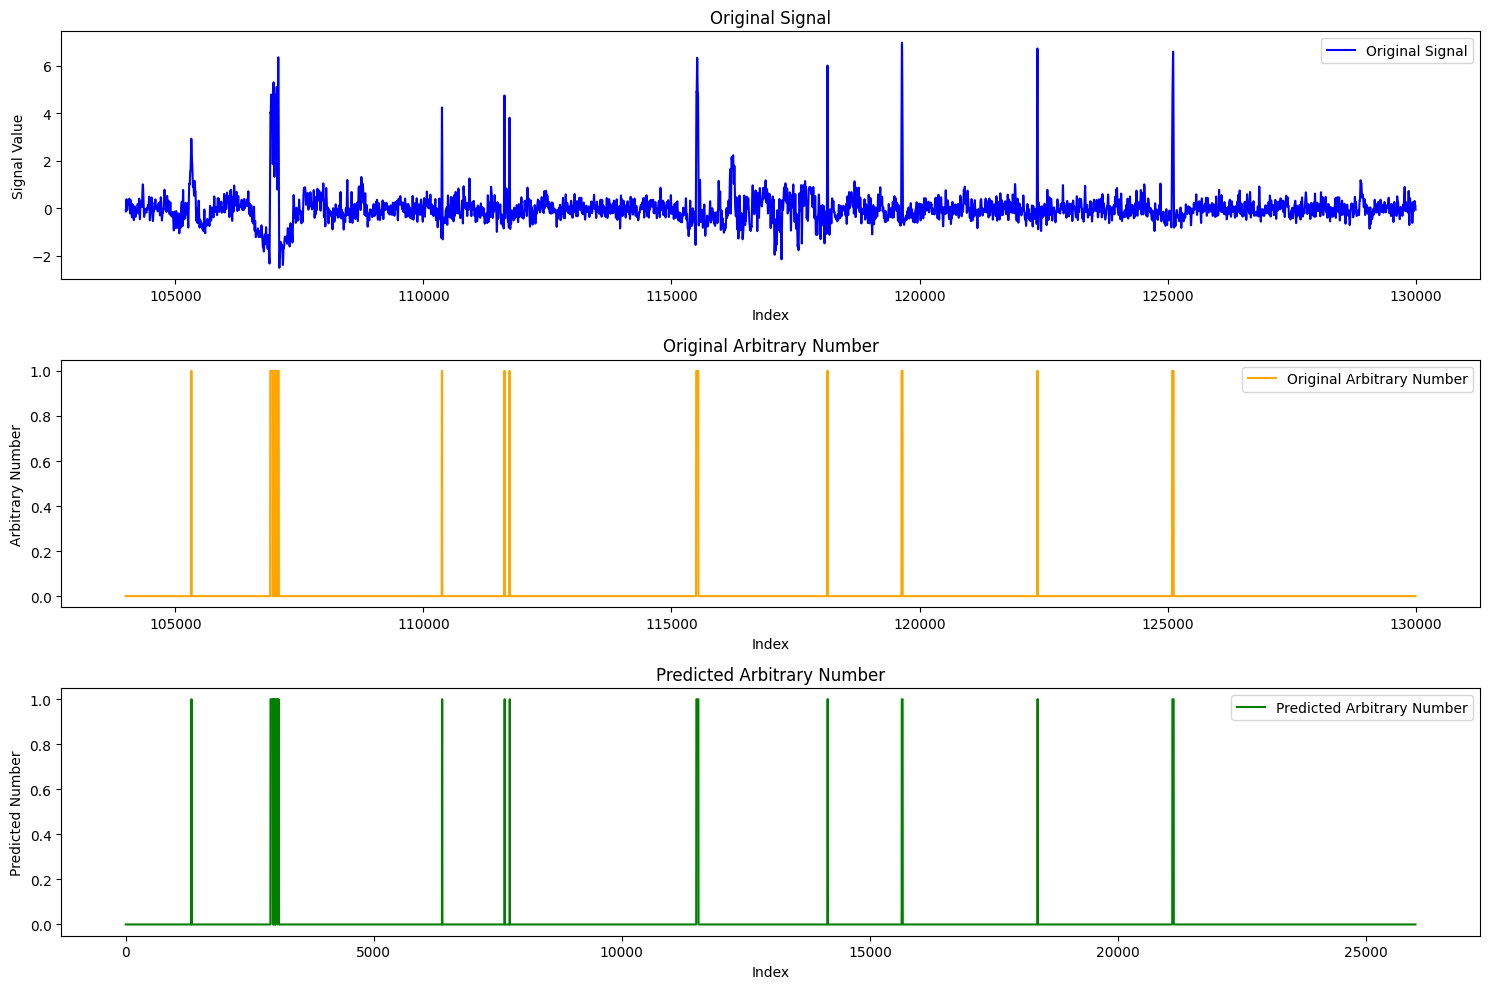

In [31]:
loss = model.evaluate([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test)
print(f'Test Loss: {loss}')

predictions = model.predict([encoder_input_data_test, decoder_input_data_test])
predicted_classes = np.argmax(predictions, axis=-1)

reshaped_data = predicted_classes.reshape(-1)
print(y_test.shape)
print(reshaped_data.shape)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test, label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test, label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
mmodel = create_model1()

In [32]:
def decode_sequence(model, input_seq):
    # Get the number of batches and sequence length
    batches = input_seq.shape[0]
    seq_len = input_seq.shape[1]

    # Initialize the target sequence with the start token
    target_seq = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
    target_seq[:, 0, 0] = 1  # Start token (class 0)

    # Initialize the decoded sequence
    decoded_sequence = np.zeros((batches, seq_len))  # Shape: (batches, seq_len)

    # Iterate over each timestep
    for i in range(seq_len):
        print(i)

        # Slice the input sequence up to the current timestep
        inp = input_seq[:, :i+1, :]  # Shape: (batches, i+1, 1)

        # Perform prediction
        res = model.predict([inp, target_seq])  # Shape: (batches, i+1, 3)

        # Get the predicted class for the last timestep
        predicted_classes = np.argmax(res[:, -1, :], axis=-1)  # Shape: (batches,)

        # Update the decoded sequence
        decoded_sequence[:, i] = predicted_classes

        # Prepare the next target sequence
        if i < seq_len - 1:
            new_dec = np.zeros((batches, 1, 3))  # Shape: (batches, 1, 3)
            new_dec[np.arange(batches), 0, predicted_classes] = 1
            target_seq = np.concatenate([target_seq, new_dec], axis=1)

    return decoded_sequence

jopa = np.expand_dims(X_test[2700:3200], axis=0)
jopa = np.expand_dims(jopa, axis=-1)
print(jopa.shape)

jopa = decode_sequence(model, jopa)

print(jopa.shape)

(1, 500, 1)
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
13
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
17
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
24
1/1 ━━━━━━

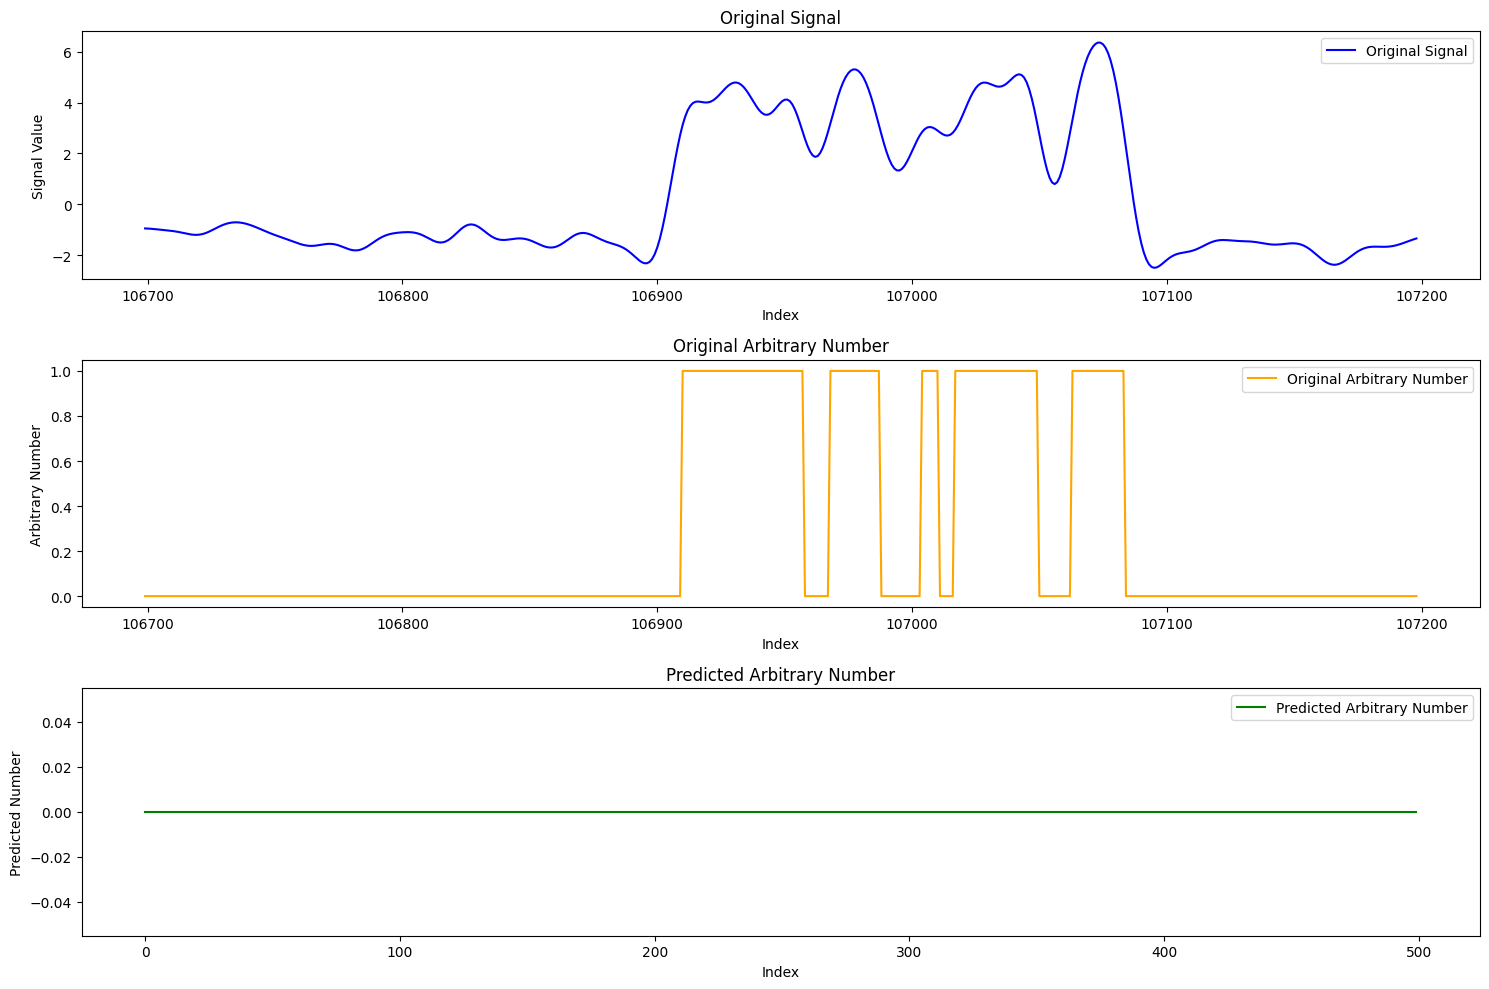

In [33]:
#predicted_classes = np.argmax(jopa, axis=-1)

reshaped_data = jopa.reshape(-1)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test[2700:3200], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test[2700:3200], label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:

points = 3100
jopa = np.expand_dims(X_test[2200:3200], axis=0)
jopa = np.expand_dims(jopa, axis=-1)

encoder_input_batch = jopa
print(encoder_input_batch.shape)

# Example decoder input (shape: (num_samples, sequence_length, 3))
decoder_input_batch = decoder_input_data_test.reshape(1, -1, 3)[:, 2200:3200, :]
print(decoder_input_batch.shape)

# Perform prediction
batch_predictions = model.predict([encoder_input_batch, decoder_input_batch])
predicted_classes = np.argmax(batch_predictions, axis=-1)  # Shape: (num_samples, sequence_length)

print(predicted_classes.shape)


(1, 1000, 1)
(1, 1000, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
(1, 1000)


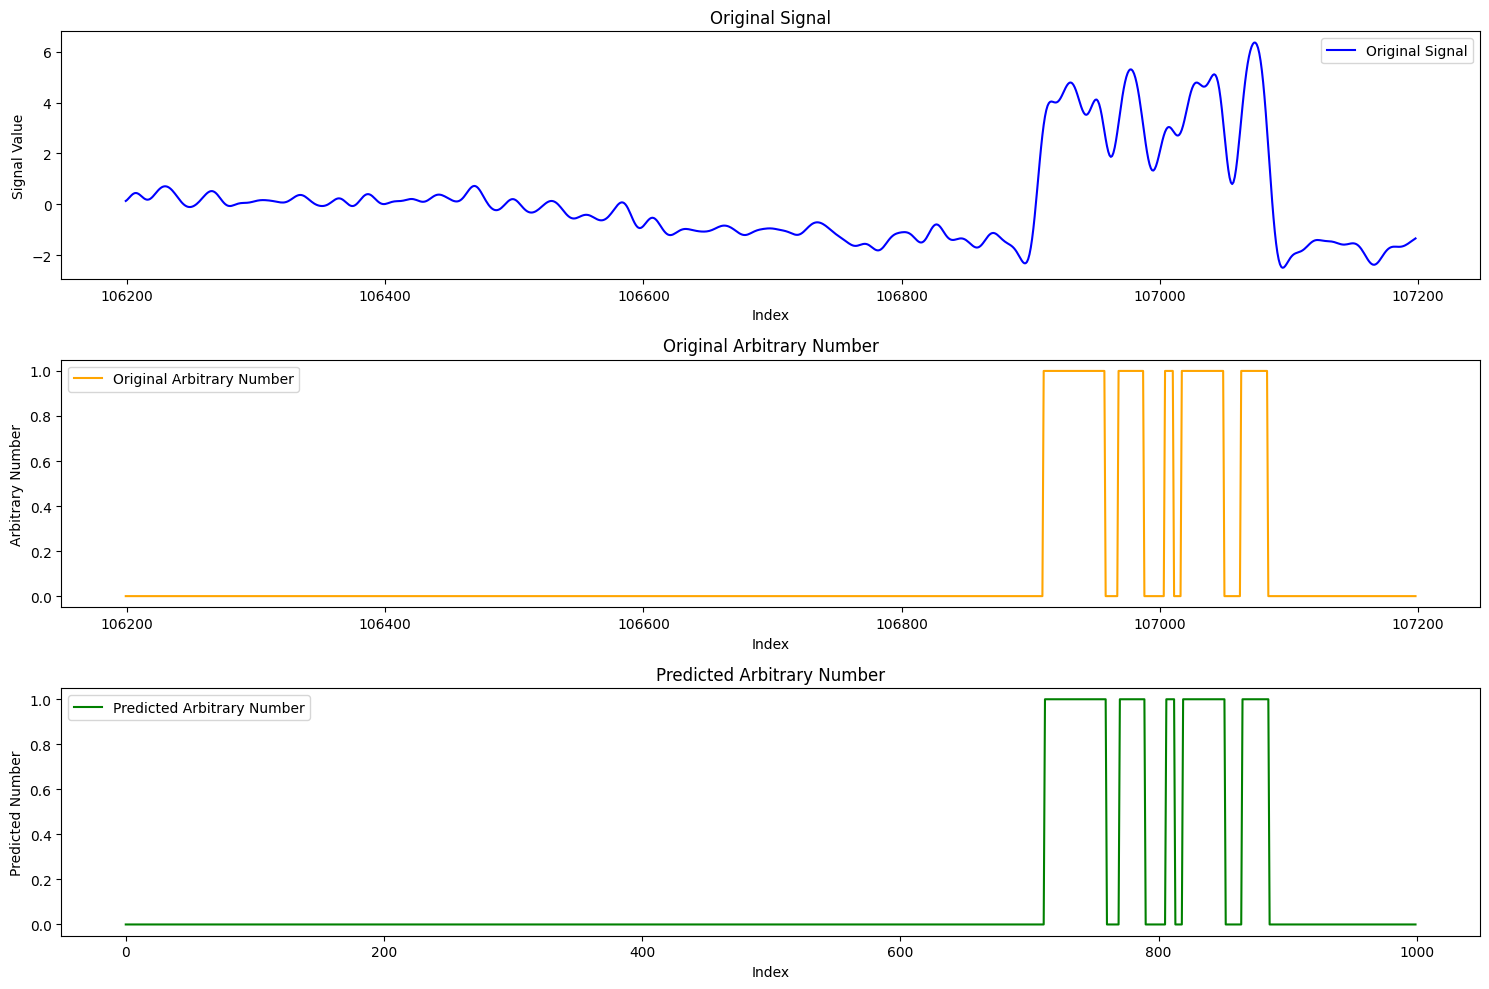

In [18]:
#predicted_classes = np.argmax(jopa, axis=-1)

reshaped_data = predicted_classes.reshape(-1)


plt.figure(figsize=(15, 10))

# Original Signal
plt.subplot(3, 1, 1)
#plt.plot(X_scaled[:, 0, :], label='Original Signal', color='blue')
plt.plot(X_test[2200:3200], label='Original Signal', color='blue')
plt.title('Original Signal')
plt.xlabel('Index')
plt.ylabel('Signal Value')
plt.legend()

# Original Arbitrary Number
plt.subplot(3, 1, 2) #data.index
plt.plot(y_test[2200:3200], label='Original Arbitrary Number', color='orange')
plt.title('Original Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Arbitrary Number')
plt.legend()

# Predicted Arbitrary Number
plt.subplot(3, 1, 3) # data.index[-len(y_test):]
plt.plot(reshaped_data, label='Predicted Arbitrary Number', color='green')
plt.title('Predicted Arbitrary Number')
plt.xlabel('Index')
plt.ylabel('Predicted Number')
plt.legend()

plt.tight_layout()
plt.show()